In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
#%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.integrate import simpson

from DataManager import DataManager



In [2]:
#Consts
#ROOT = os.path.dirname(os.path.realpath(__file__))
ROOT = os.getcwd()
M81_Path = ROOT+'/data/M81/'
NGC2281_Path = ROOT+'/data/NGC2281/'
OUT_Path = ROOT+'/img/'
GAIN = 1.56

#Get Data
'''
Object Structure of return from DataManager.retrieve():
{'Flat_V': []
,'Flat_R': []
,'Flat_B': []
,'Light_V': []
,'Light_R': []
,'Light_B': []
,'Dark': []
,'Bias': []
}
'''
DM = DataManager()

DM.fetchData(M81_Path)
M81 = DM.retrieve()
DM.clear()

DM.fetchData(NGC2281_Path)
NGC2281 = DM.retrieve()
DM.clear()

## Exposure Times of NGC2281

- **Light (v/r)**: 5 s
- **Light (b)**: 10 s
- **Dark**: 30 s
- **Bias**: 0 s
- **Flat (b)**: 4 s
- **Flat (r)**: 3.5 s
- **Flat (v)**: 4 s

In [3]:
# Defining the frames, aka here are all the masterframes for each of the pictures.
flat_v = NGC2281["Flat_V"]
flat_r = NGC2281["Flat_R"]
flat_b = NGC2281["Flat_B"]
light_v = NGC2281["Light_V"]
light_r = NGC2281["Light_R"]
light_b = NGC2281["Light_B"]
dark = NGC2281["Dark"]
bias = NGC2281["Bias"]
# exposure times:
exposure_time_dark = 30
exposure_time_flat_b = 4
exposure_time_flat_v = 4
exposure_time_flat_r = 3.5
exposure_time_light_b = 10
exposure_time_light_v = 5
exposure_time_light_r = 5

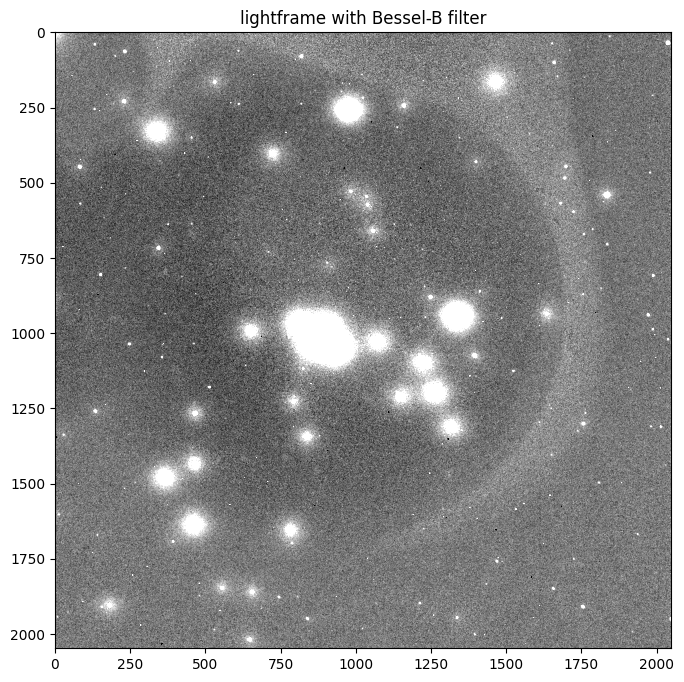

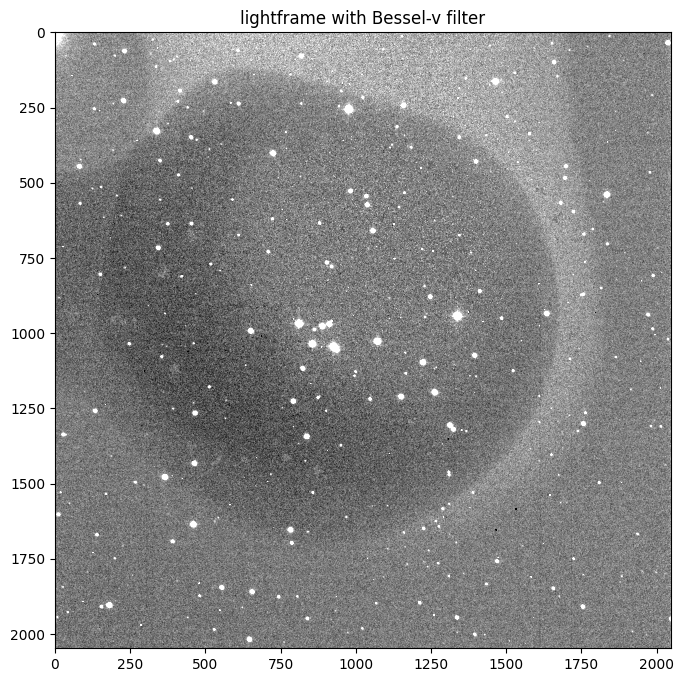

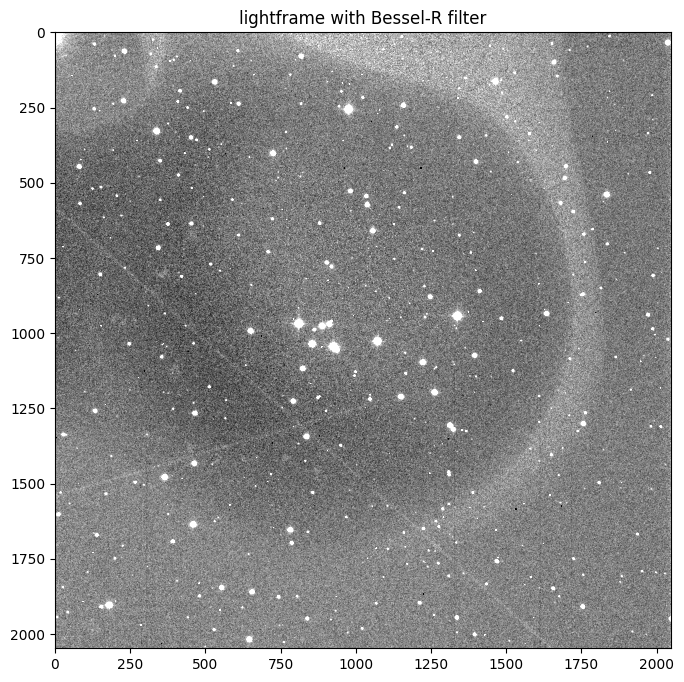

In [4]:
%matplotlib inline
# Correction of the scienceframes: TODO: Check how the exposure time should be done
# HEREEEEEEE I am doing the (hopefully) correct Data Reduction:

# first, remove the Bias from the Dark and scale the Dark down to 1 sek.:
master_dark_1_sek = (dark - bias) / exposure_time_dark

# now lets correct the flats for their respective filters and axposure times:
# for that, just multiply the down scaled dark y the respective exposure times,
# as a last step normalise the flat by dividing by the max(flat):

master_flat_b = ((flat_b - bias) - (master_dark_1_sek * exposure_time_flat_b))
master_flat_b = master_flat_b / np.max(master_flat_b)

master_flat_v = ((flat_v - bias) - (master_dark_1_sek * exposure_time_flat_v))
master_flat_v = master_flat_v / np.max(master_flat_v)

master_flat_r = ((flat_r - bias) - (master_dark_1_sek * exposure_time_flat_r))
master_flat_r = master_flat_r / np.max(master_flat_r)

# now pretty much the same for the light framse:

master_light_b = ((light_b - bias) - (master_dark_1_sek * exposure_time_light_b))
corrected_light_b = master_light_b / master_flat_b

master_light_v = ((light_v - bias) - (master_dark_1_sek * exposure_time_light_v))
corrected_light_v = master_light_v / master_flat_v

master_light_r = ((light_r - bias) - (master_dark_1_sek * exposure_time_light_r))
corrected_light_r = master_light_r / master_flat_r


# Plotting the three images:
fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-B filter")
plt.imshow(corrected_light_b, cmap = 'gray', vmin = np.percentile(corrected_light_b, 5), vmax = np.percentile(corrected_light_b, 95))
plt.show()

fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-v filter")
plt.imshow(corrected_light_v, cmap = 'gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.show()

fig = plt.figure(figsize=(8,8))
plt.title("lightframe with Bessel-R filter")
plt.imshow(corrected_light_r, cmap = 'gray', vmin = np.percentile(corrected_light_r, 5), vmax = np.percentile(corrected_light_r, 95))
plt.show()
 


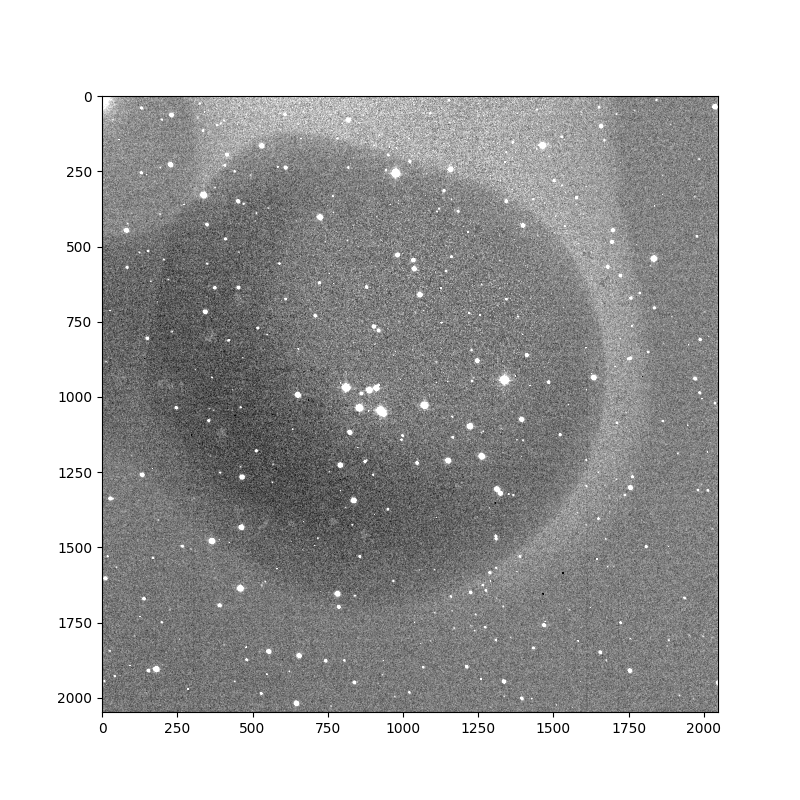

(2048, 2048) -75293.01976744186 531843.5750740705


In [5]:
#%matplotlib notebook
%matplotlib widget
#%matplotlib inline
# This is needed to allow interactivity and showing the position of the mouse to find the stars.

fig = plt.figure(figsize=(8,8))
plt.imshow(corrected_light_v, cmap = 'gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.show()
print(corrected_light_v.shape, np.min(corrected_light_v), np.max(corrected_light_v))

Filename: d:\Julian\Documents\UNI\astro\Praktikum\AstroPrak\Nordkuppel/data/NGC2281/0001_Flat_V.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (2048, 2048)   uint16   
SIMPLE  =                    T                                                  BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 2048 /fastest changing axis                           NAXIS2  =                 2048 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2025-03-21T18:13:51' /YYYY-MM-DDThh:mm:ss observation start, UT      EXPTIME =   4.0000000000000000 /Exposure time in seconds                        EXPOSURE=   4.0000000000000000 /Exposure time in s

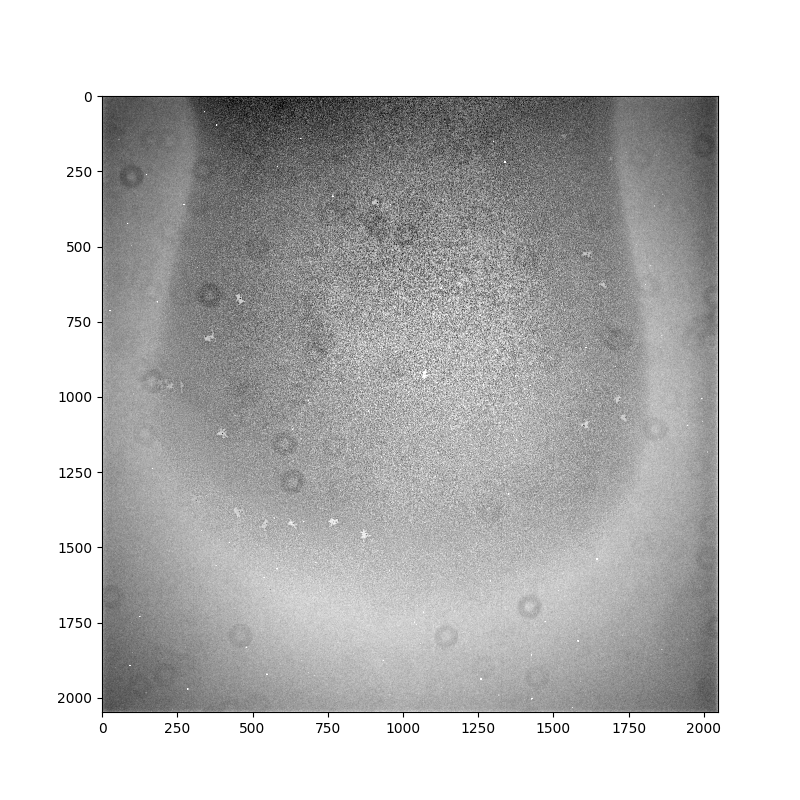

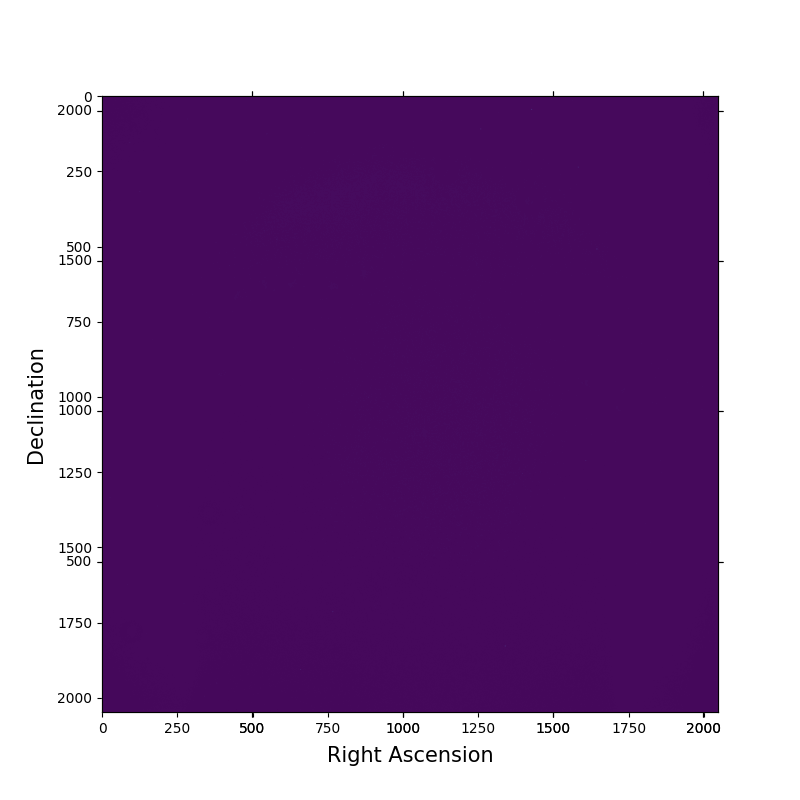

In [6]:
with fits.open(f'{NGC2281_Path}0001_Flat_V.fits') as file:
    header = file[0].header
    data = file[0].data
    n_axis = file[0].header["NAXIS"]
    file.info()

print(header)
print("--------------------------------------")
print(data)
print("--------------------------------------")
print(f"How many axes: {n_axis}")
print("--------------------------------------")
print(f' Number of objects in NAXIS1: {header["NAXIS1"]} \n')
print(f' Number of objects in NAXIS2: {header["NAXIS2"]} \n')



print(f"data[0] and len(): {data[0]}, {len(data[0])} \n")
print(f"data[1] and len(): {data[1]}, {len(data[1])} \n")
print(len(data))
#data ist eine Matrix mit 1365 reihen in diesen sind jeweils 1365 werte drinnen


plt.imshow(data, cmap='gray', vmin = np.percentile(data, 5), vmax = np.percentile(data, 95))
plt.show()

wcs = WCS(header)

plt.subplot(projection=wcs)
plt.imshow(data, origin='lower')
plt.grid(True)
plt.xlabel('Right Ascension', size=15)
plt.ylabel('Declination', size=15)
plt.xticks(fontsize=18) # sets the size of the numbers on the axis
plt.yticks(fontsize=18)
plt.savefig(OUT_Path+"image_with_wcs.svg", bbox_inches = "tight") # bbox tight removes as much white space as possible
plt.show()
# für RGB bild numpy.destack
# schaun dass bilder azwischen 0 und 1 normier sind
# 

In [7]:

# 1. Stunden, Minuten, Sekunden -> Sekunden insgesamt
def hms_to_seconds(hour, minute, second):
    return hour * 3600 + minute * 60 + second

# 2. Sekunden -> Stunden, Minuten, Sekunden
def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    sec = seconds % 60
    return hours, minutes, sec

# 3. Grad, Bogenminuten, Bogensekunden -> Bogensekunden insgesamt
def dms_to_arcseconds(degrees, arcminutes, arcseconds):
    return degrees * 3600 + arcminutes * 60 + arcseconds

# 4. Bogensekunden -> Grad, Bogenminuten, Bogensekunden
def arcseconds_to_dms(arcseconds):
    degrees = arcseconds // 3600
    arcminutes = (arcseconds % 3600) // 60
    sec = arcseconds % 60
    return degrees, arcminutes, sec

# alle referenzsternen pixel werte star(X,Y), 1bis5 von Philipp, 6bis9 von Elias
reference_star_1_pix = (1466, 1758)
reference_star_2_pix = (392, 1691)
reference_star_3_pix = (950, 1372)
reference_star_4_pix = (1260, 1196)
reference_star_5_pix = (246, 1036)
reference_star_6_pix = (int(np.mean([1626.8, 1641.7])), int(np.mean([942.3, 928.4])))
reference_star_7_pix = (int(np.mean([876.58, 883.14])), int(np.mean([637.87, 631.86])))
reference_star_8_pix = (int(np.mean([1675.69, 1684.49])), int(np.mean([573.26, 562.85])))
reference_star_9_pix = (int(np.mean([717.6, 731.9])), int(np.mean([409.0, 396.0])))

# alle referenzterne sky coordinate werte:
# originalerweise RA [hh:mm:ss]stunden, DEC [dd:mm:ss]degree
# neue version: RA [seconds], DEC [arcseconds]
reference_star_1_coord = (hms_to_seconds(6, 48, 48.52), dms_to_arcseconds(41, 11, 28.4))
reference_star_2_coord = (hms_to_seconds(6, 47, 55.57), dms_to_arcseconds(41, 11, 10.0))
reference_star_3_coord = (hms_to_seconds(6, 48, 22.51), dms_to_arcseconds(41, 8, 3.9))
reference_star_4_coord = (hms_to_seconds(6, 48, 37.54), dms_to_arcseconds(41, 6, 21.1))
reference_star_5_coord = (hms_to_seconds(6, 47, 47.56), dms_to_arcseconds(41, 5, 8.7))
reference_star_6_coord = (hms_to_seconds(6, 48, 55.36), dms_to_arcseconds(41, 3, 49.3))
reference_star_7_coord = (hms_to_seconds(6, 48, 17.94), dms_to_arcseconds(41, 1, 15.9))
reference_star_8_coord = (hms_to_seconds(6, 48, 57.06), dms_to_arcseconds(41, 0, 25.1))
reference_star_9_coord = (hms_to_seconds(6, 48, 10.05), dms_to_arcseconds(40, 59, 10.1))

# alle neuen sterne in Pixelwerten (X,Y): 1bis7 von Elias, 8bis14 von Philipp
new_star_1_pix = (int(np.mean([1751.46, 1759.07])), int(np.mean([875.53, 876.92])))
new_star_2_pix = (int(np.mean([1825.6, 1844.0])), int(np.mean([548.1, 530.9])))
new_star_3_pix = (int(np.mean([1393.1, 1404.0])), int(np.mean([435.7, 424.9])))
new_star_4_pix = (int(np.mean([1407.7, 1417.09])), int(np.mean([864.95, 856.15])))
new_star_5_pix = (int(np.mean([1152.68, 1164.98])), int(np.mean([249.38, 237.18])))
new_star_6_pix = (int(np.mean([449.66, 457.14])), int(np.mean([640.46, 632.23])))
new_star_7_pix = (int(np.mean([329.2, 345.6])), int(np.mean([337.8, 318.8])))
new_star_8_pix = (1073, 1024)
new_star_9_pix = (365, 1476)
new_star_10_pix = (655, 1857)
new_star_11_pix = (1212, 1897)
new_star_12_pix = (1808, 1496)
new_star_13_pix = (465, 1266)
new_star_14_pix = (1755, 1299)

print(reference_star_1_pix)
#print(reference_star_7_pix)
#print(reference_star_8_pix)
#print(reference_star_9_pix)
print(reference_star_1_coord)
#print(reference_star_7_coord)
#print(reference_star_8_coord)
#print(reference_star_9_pix)
#print(reference_star_9_coord)


print("<=========================================>")
print(arcseconds_to_dms(reference_star_6_coord[1]))

(1466, 1758)
(24528.52, 148288.4)
<=========================================>
(41.0, 3.0, 49.29999999998836)


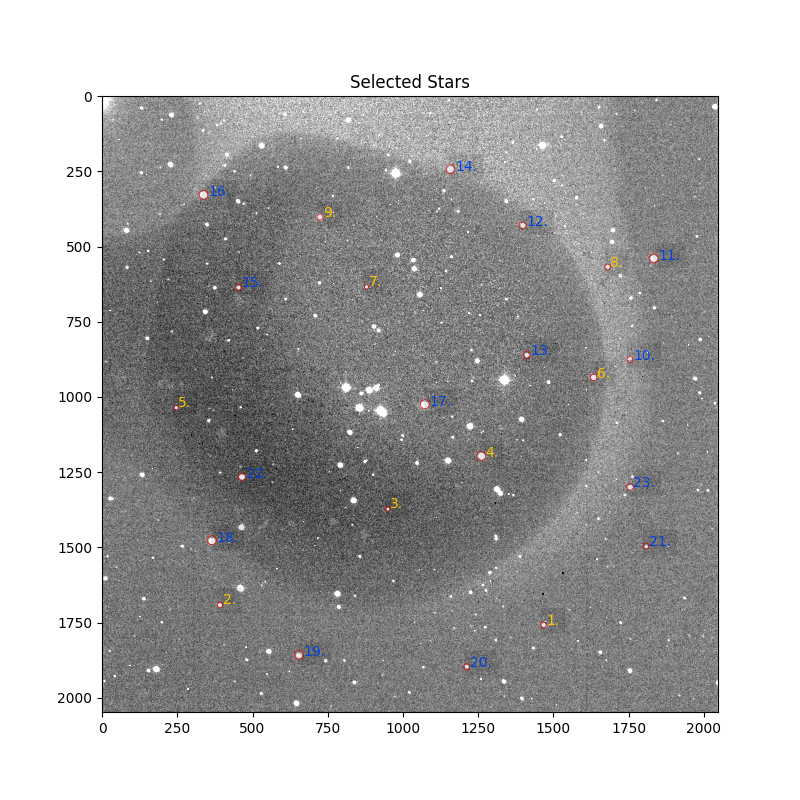

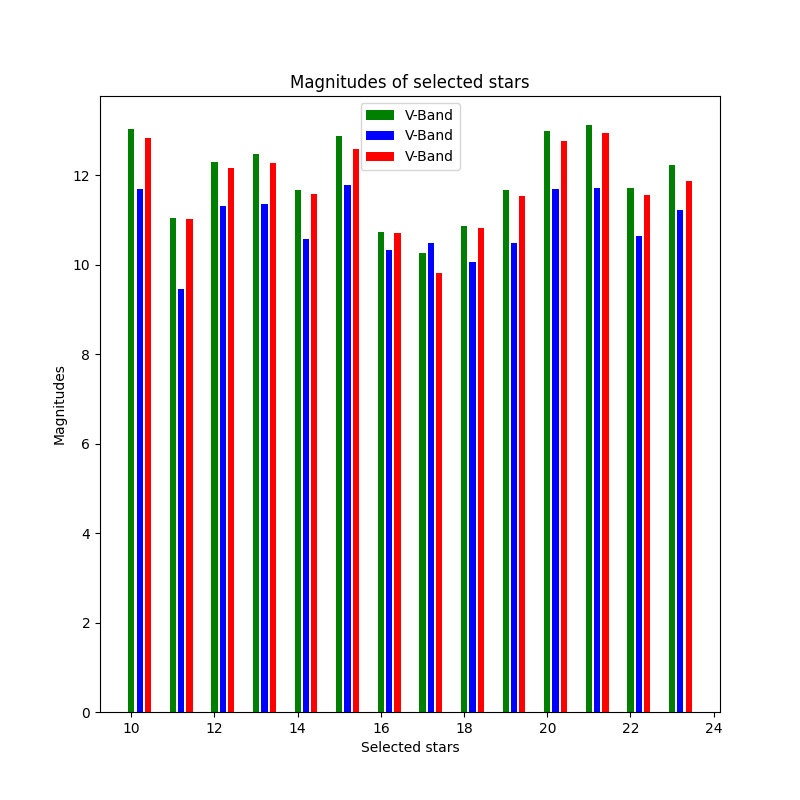

In [8]:
#Circle midpoints (x, y) from reference stars
stars_ref = [
    reference_star_1_pix
    ,reference_star_2_pix
    ,reference_star_3_pix
    ,reference_star_4_pix
    ,reference_star_5_pix
    ,reference_star_6_pix
    ,reference_star_7_pix
    ,reference_star_8_pix
    ,reference_star_9_pix
]
    #--------------------
stars_new = [
    new_star_1_pix
    ,new_star_2_pix
    ,new_star_3_pix
    ,new_star_4_pix
    ,new_star_5_pix
    ,new_star_6_pix
    ,new_star_7_pix
    ,new_star_8_pix
    ,new_star_9_pix
    ,new_star_10_pix
    ,new_star_11_pix
    ,new_star_12_pix
    ,new_star_13_pix
    ,new_star_14_pix
]

#Circle sizes
radii_ref = [
    10
    ,9
    ,8
    ,15
    ,7
    ,11
    ,7
    ,10
    ,10
]
    #-----
radii_new = [
    10
    ,15
    ,12
    ,12
    ,15
    ,10
    ,15
    ,15
    ,15
    ,15
    ,10
    ,10
    ,12
    ,11
]

#Visualization
def plot_marked_stars(image, centers, radii):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap = 'gray', vmin = np.percentile(image, 5), vmax = np.percentile(image, 95))
    
    # Overlay circular patches
    for i, (center, radius) in enumerate(zip(centers, radii)):
        circle = Circle(center, radius, color='red', fill=False, linewidth=0.5)
        ax.add_patch(circle)
        if i <= 8:
            c = '#FFC500'
        else:
            c = '#0042DD'
        ax.text(center[0]+radius, center[1]+radius, f"{i+1}.", color=c, fontsize=10, ha='left', va='bottom', 
                bbox=dict(facecolor='black', alpha=0.1, edgecolor='none'))
    
    ax.set_title("Selected Stars")
    plt.savefig(OUT_Path+"selections.svg")
    plt.show()


def calcMag(fluxes, fluxes_ref, mag_ref):
    mags = []
    for i, f_ref in enumerate(fluxes_ref):
        temp = []
        for f in fluxes:
            mag_new = -2.5*np.log10(np.divide(f, f_ref)) + mag_ref[i]
            temp.append(mag_new)
        mags.append(temp)
    return np.average(mags, axis=0)


def correctFlux(fluxes_ref, expTime):
    return np.divide(np.multiply(fluxes_ref, GAIN), expTime)


mag_ref = pd.DataFrame(columns=["B_mag", "V_mag", "R_mag"],
                       data= np.array([
                           [13.96, 12.71, 12.35]
                           ,[13.63, 12.92, 12.75]
                           ,[15.63, 14.53, 14.12]
                           ,[10.38, 10.14, 10.21]
                           ,[14.26, 13.6, 13.44]
                           ,[11.97, 11.4, 11.3]
                           ,[14.48, 13.76, 13.55]
                           ,[14.25, 13.49, 13.28]
                           ,[11.39, 10.92, 10.85]
                           ]))


stars = stars_ref + stars_new
radii = radii_ref + radii_new
plot_marked_stars(corrected_light_v, stars, radii)


fluxes_ref_V = DM.circularSelection(corrected_light_v, stars_ref, radii_ref)
fluxes_new_V = DM.circularSelection(corrected_light_v, stars_new, radii_new)
fluxes_ref_V_Corrected = correctFlux(fluxes_ref_V, exposure_time_light_v)
fluxes_new_V_Corrected = correctFlux(fluxes_new_V, exposure_time_light_v)

fluxes_ref_B = DM.circularSelection(corrected_light_b, stars_ref, radii_ref)
fluxes_new_B = DM.circularSelection(corrected_light_b, stars_new, radii_new)
fluxes_ref_B_Corrected = correctFlux(fluxes_ref_B, exposure_time_light_b)
fluxes_new_B_Corrected = correctFlux(fluxes_new_B, exposure_time_light_b)

fluxes_ref_R = DM.circularSelection(corrected_light_r, stars_ref, radii_ref)
fluxes_new_R = DM.circularSelection(corrected_light_r, stars_new, radii_new)
fluxes_ref_R_Corrected = correctFlux(fluxes_ref_R, exposure_time_light_r)
fluxes_new_R_Corrected = correctFlux(fluxes_new_R, exposure_time_light_r)

mag_V = calcMag(fluxes_new_V_Corrected, fluxes_ref_V_Corrected, mag_ref['V_mag'])
mag_B = calcMag(fluxes_new_B_Corrected, fluxes_ref_R_Corrected, mag_ref['B_mag'])
mag_R = calcMag(fluxes_new_R_Corrected, fluxes_ref_R_Corrected, mag_ref['R_mag'])

results = pd.DataFrame(columns=["B_flux", "V_flux", "R_flux", "B_mag", "V_mag", "R_mag"])
results["B_flux"] = np.round(fluxes_new_B_Corrected, 3)
results["V_flux"] = np.round(fluxes_new_V_Corrected, 3)
results["R_flux"] = np.round(fluxes_new_R_Corrected, 3)
results["B_mag"] = np.round(mag_B, 3)
results["V_mag"] = np.round(mag_V, 3)
results["R_mag"] = np.round(mag_R, 3)
results.to_csv(ROOT+'/fluxes_luminosities', index_label='sel_Stars')

 
x = np.arange(10, 10+len(stars_new), 1)
fix, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.bar(x, mag_V, 0.15, label='V-Band', color='green')
ax.bar(x + 0.2, mag_B, 0.15, label='V-Band', color='blue')
ax.bar(x + 0.4, mag_R, 0.15, label='V-Band', color='red')
ax.set_title('Magnitudes of selected stars')
ax.set_xlabel('Selected stars')
ax.set_ylabel('Magnitudes')
plt.legend()
plt.savefig(OUT_Path+'selected-stars_bar.svg')
plt.show()



Schwächste erfasste Sternhelligkeit: 162196.91360486817
Position des schwächsten Sterns: x = 1988.22, y = 809.04


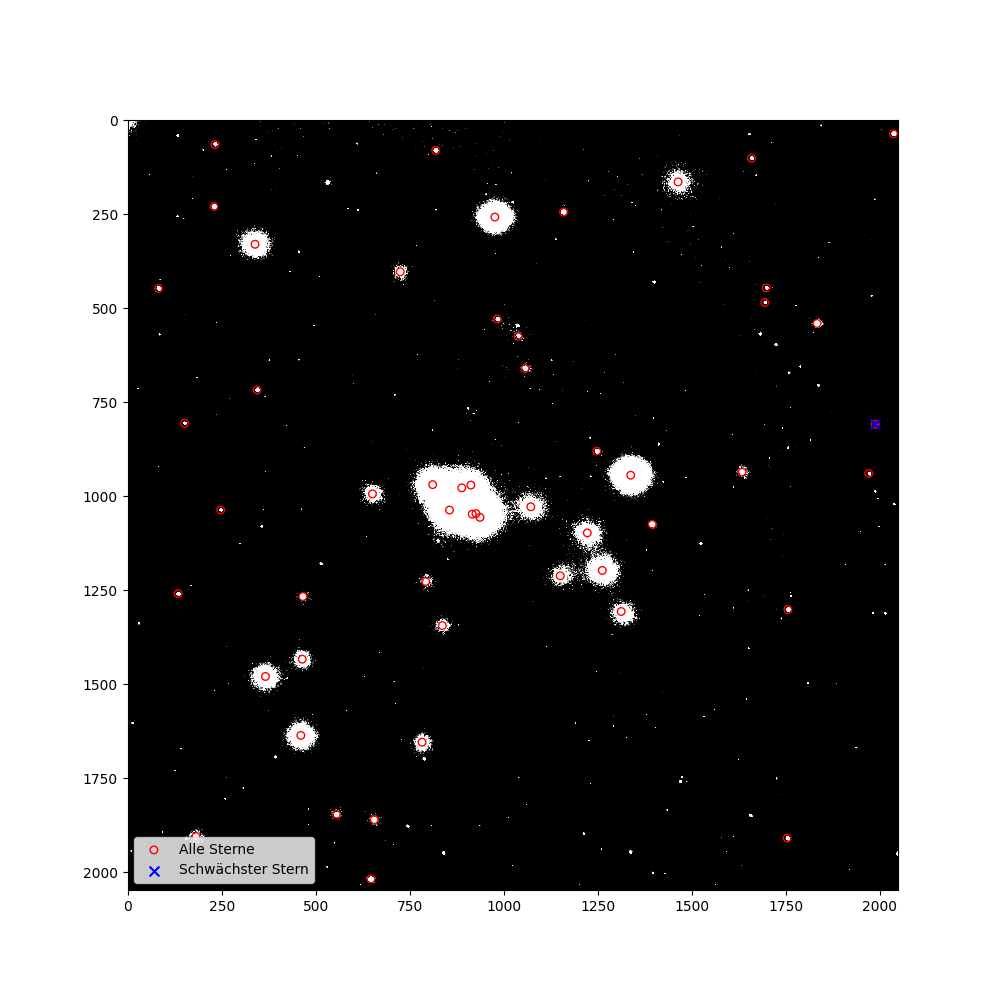

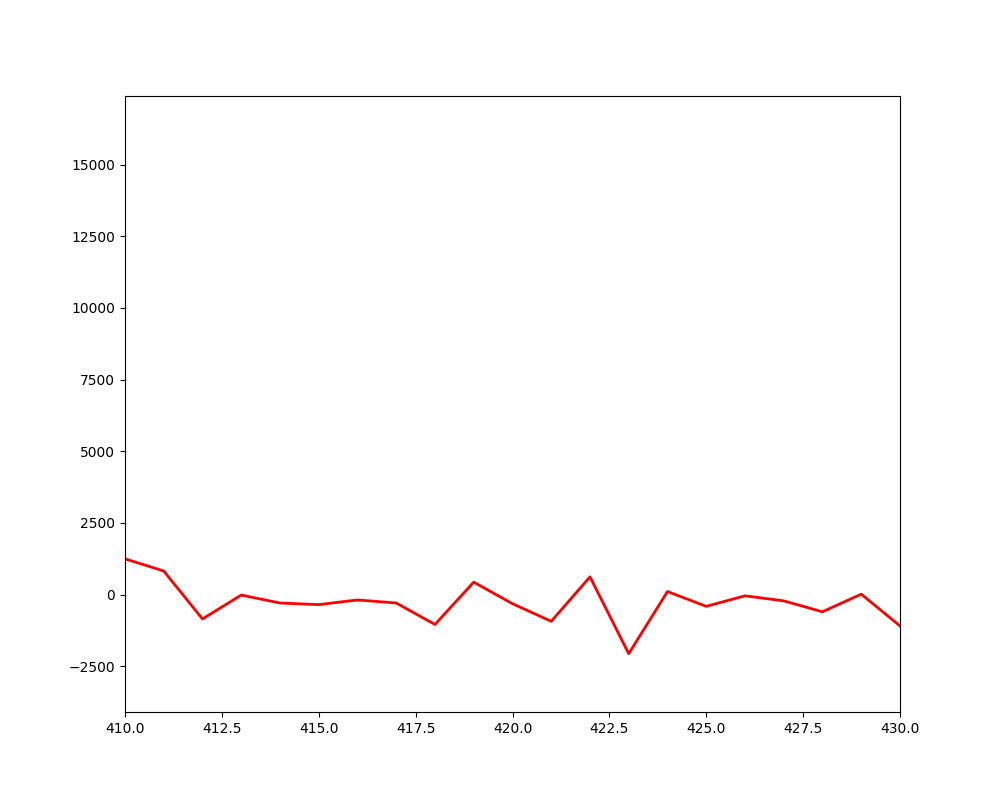

In [9]:
# Lade dein Bild (ersetze 'your_image' mit deinem Array oder Pfad)
image = corrected_light_b  # Dein bearbeitetes Bild als NumPy-Array

# **1. Hintergrund berechnen**
mean, median, std = sigma_clipped_stats(image, sigma=4.0)
threshold = median + (4.0 * std)  # Setze Erkennungsgrenze für Sterne

# **2. Sterne mit DAOStarFinder suchen**
daofind = DAOStarFinder(fwhm=3.0, threshold=threshold)
sources = daofind(image - median)  # Hintergrund abziehen, eigentlich stand hier daofind(image - median)

# **3. Schwächsten Stern finden**
min_flux_index = np.argmin(sources['flux'])
min_flux = sources['flux'][min_flux_index]
min_x = sources['xcentroid'][min_flux_index]
min_y = sources['ycentroid'][min_flux_index]

print(f"Schwächste erfasste Sternhelligkeit: {min_flux}")
print(f"Position des schwächsten Sterns: x = {min_x:.2f}, y = {min_y:.2f}")

# **4. Visualisieren**
plt.figure(figsize=(10, 10))
plt.imshow(image - median, cmap='gray', vmin = np.percentile(corrected_light_v, 5), vmax = np.percentile(corrected_light_v, 95))
plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none', label="Alle Sterne")
plt.scatter(min_x, min_y, s=50, facecolor='blue', label="Schwächster Stern", marker="x")
plt.legend()
plt.show()

# here i try to do a 1D cutout of a strar to find out its FWHM:
plt.figure(figsize=(10, 8))
plt.plot(((image - median)[int(min_y), :]), color = 'red', label='1D spectrum of a given star', linewidth=2)
plt.xlim(410, 430)
# now we do a guß fit over it to find out the FWHM:

plt.show()


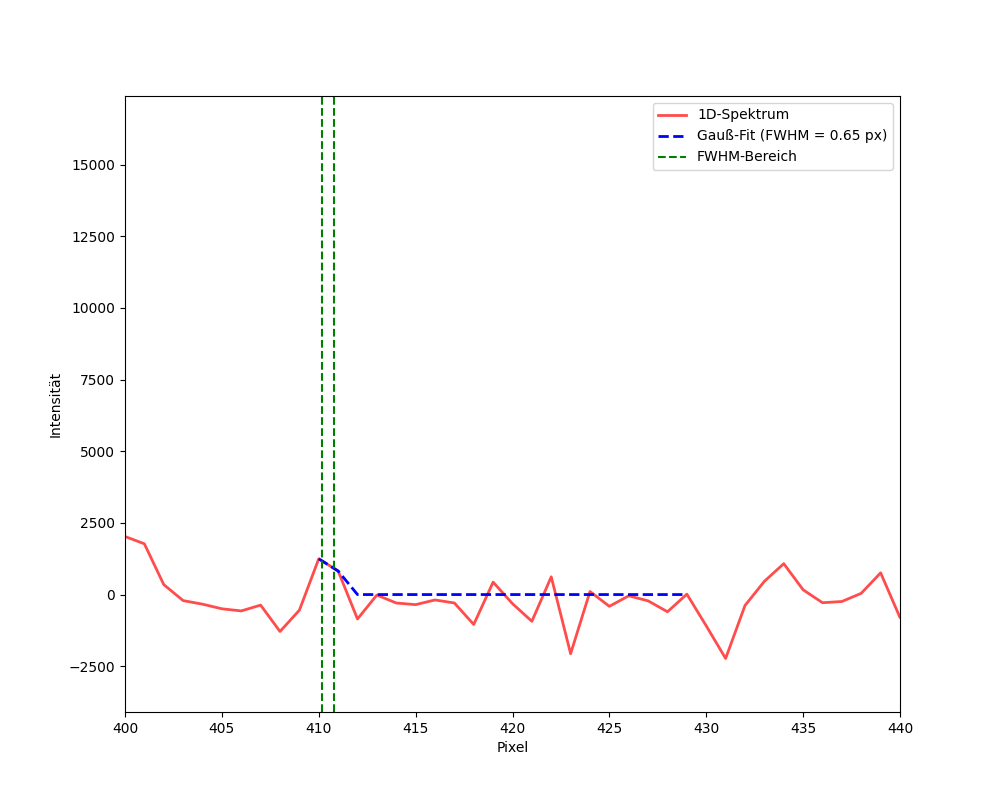

FWHM des Sterns: 0.65 Pixel
einf extrahierte FWHM: 0.6470464769893923


In [10]:
# 1D-Profil extrahieren (Zeile in y-Richtung)
y_index = int(min_y)  # Die Zeile mit dem Stern
x_values = np.arange(image.shape[1])  # x-Pixel-Werte
y_values = (image - median)[y_index, :]  # Intensitäten entlang der Zeile

# Auswahl eines Ausschnitts für den Fit
x_fit = x_values[410:430]
y_fit = y_values[410:430]

# Gauß-Modell definieren (mit Startwerten)
gauss_init = models.Gaussian1D(amplitude=np.max(y_fit), mean=np.argmax(y_fit) + 410, stddev=1.5)

# Fit-Funktion
fitter = fitting.LevMarLSQFitter()
gauss_fit = fitter(gauss_init, x_fit, y_fit)

# FWHM berechnen (Formel für Gauß-Kurve: FWHM = 2.355 * stddev)
fwhm = 2.355 * gauss_fit.stddev.value
 
# Plotten
plt.figure(figsize=(10, 8))
plt.plot(x_values, y_values, color='red', label='1D-Spektrum', linewidth=2, alpha=0.7)
plt.plot(x_fit, gauss_fit(x_fit), color='blue', linestyle="--", label=f'Gauß-Fit (FWHM = {fwhm:.2f} px)', linewidth=2)
plt.axvline(gauss_fit.mean.value - fwhm / 2, color='green', linestyle="--", label="FWHM-Bereich")
plt.axvline(gauss_fit.mean.value + fwhm / 2, color='green', linestyle="--")
plt.xlim(400, 440)
plt.xlabel("Pixel")
plt.ylabel("Intensität")
plt.legend()
plt.show()

print(f"FWHM des Sterns: {fwhm:.2f} Pixel")
print(f"einf extrahierte FWHM: {gauss_fit.fwhm}")

227 227
einf extrahierte FWHM: 4.258567890014556


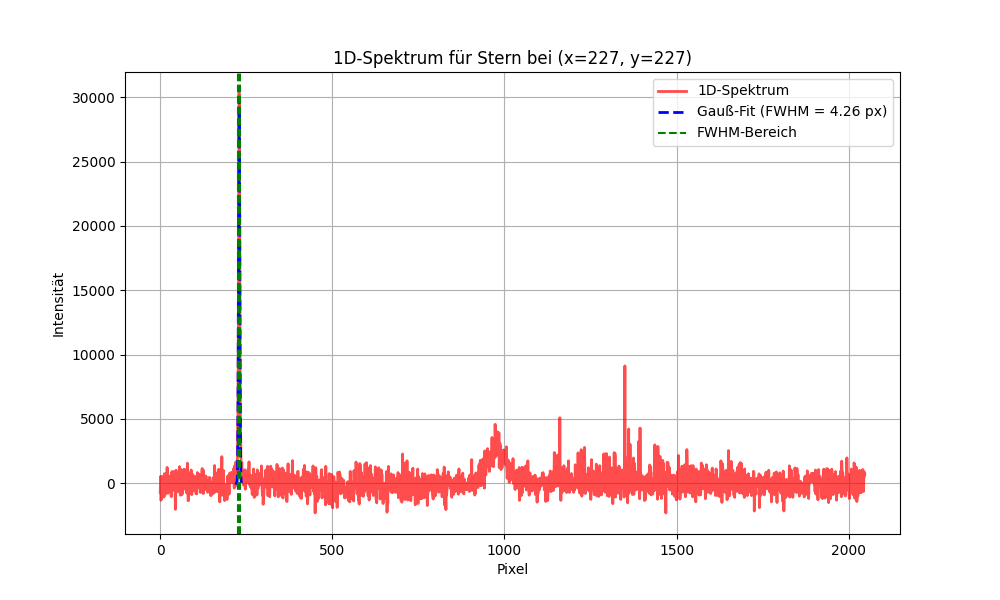

FWHM des Sterns: 4.26 Pixel
einf extrahierte FWHM: 4.258567890014556


In [11]:
def measure_fwhm(image, x, y, fit_range=(10, 10)):
    """
    Extrahiert das 1D-Spektrum eines Sterns aus einem Bild und bestimmt die FWHM per Gauß-Fit.
    
    Parameter:
    - image: 2D NumPy-Array (das kalibrierte Bild)
    - x, y: Pixel-Koordinaten des Sterns
    - fit_range: Tupel (links, rechts) für den Fit-Bereich um x
    
    Rückgabe:
    - fwhm: Full Width at Half Maximum (FWHM) in Pixel
    - gauß_fit: Das angepasste Modell
    """
    # Intensitätswerte entlang der Zeile des Sterns (y-Richtung fix)
    y_index = int(y)
    x_values = np.arange(image.shape[1])  # Alle x-Pixel
    y_values = image[y_index, :]  # Intensitäten entlang der Zeile

    # Auswahl des Fit-Bereichs um x
    x_min = max(0, int(x - fit_range[0]))
    x_max = min(image.shape[1], int(x + fit_range[1]))
    x_fit = x_values[x_min:x_max]
    y_fit = y_values[x_min:x_max]

    # Gauß-Fit vorbereiten (Startwerte: Peak-Position, Amplitude, Stddev)
    gauss_init = models.Gaussian1D(amplitude=np.max(y_fit), mean=x, stddev=2.0)

    # Fit durchführen
    fitter = fitting.LevMarLSQFitter()
    gauss_fit = fitter(gauss_init, x_fit, y_fit)

    # FWHM berechnen (FWHM = 2.355 * Stddev)
    fwhm = 2.355 * gauss_fit.stddev.value
    print(f"einf extrahierte FWHM: {gauss_fit.fwhm}")

    # Ergebnisse plotten
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, color='red', label='1D-Spektrum', linewidth=2, alpha=0.7)
    plt.plot(x_fit, gauss_fit(x_fit), color='blue', linestyle="--", label=f'Gauß-Fit (FWHM = {fwhm:.2f} px)', linewidth=2)
    plt.axvline(gauss_fit.mean.value - fwhm / 2, color='green', linestyle="--", label="FWHM-Bereich")
    plt.axvline(gauss_fit.mean.value + fwhm / 2, color='green', linestyle="--")
    plt.xlabel("Pixel")
    plt.ylabel("Intensität")
    plt.title(f"1D-Spektrum für Stern bei (x={x}, y={y})")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"FWHM des Sterns: {fwhm:.2f} Pixel")
    print(f"einf extrahierte FWHM: {gauss_fit.fwhm}")
    return fwhm, gauss_fit

star_1 = [421, 812]
star_2 = [834, 1341]
star_3 = [1809, 1496]
star_4 = [1576, 335]
star_5 = [227, 227]

x_star, y_star = star_5  # Beispielhafte Position eines Sterns

print(x_star, y_star)
fwhm, fitted_model = measure_fwhm(image - median, x_star, y_star)

Schwächste Sternhelligkeit: 111720.52119642524
Position des schwächsten Sterns: x = 1523.00, y = 1125.61


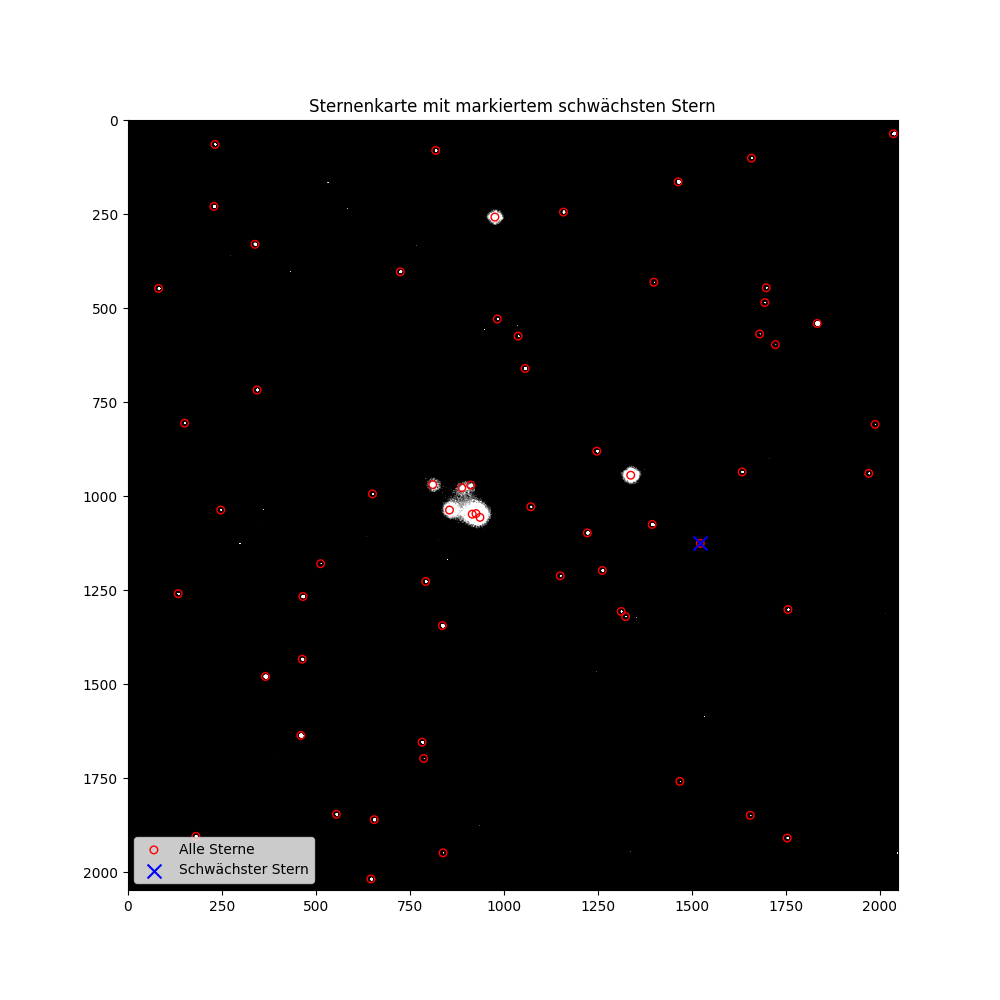

min_flux: 111720.52119642524
min_x: 1523.0040031127728
min_y: 1125.6140476906614


In [12]:
def find_faintest_star(image, fwhm=3.0, sigma=3.0):
    """
    Findet den schwächsten Stern in einem Bild mit photutils.
    
    Parameter:
    - image: 2D NumPy-Array, das das bearbeitete Himmelsbild enthält
    - fwhm: Erwartete FWHM der Sterne in Pixeln
    - sigma: Multiplikator für den Rausch-Schwellenwert

    Rückgabe:
    - min_flux: Flux des schwächsten Sterns
    - min_x, min_y: Koordinaten des schwächsten Sterns
    - sources: Tabelle mit allen gefundenen Sternen
    """
    # **1. Hintergrundberechnung & Schwellenwert**
    mean, median, std = sigma_clipped_stats(image, sigma=sigma)
    threshold = median + (sigma * std)

    # **2. Sterne mit DAOStarFinder suchen**
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold) # 
    sources = daofind(image - median)  # Hintergrund entfernen

    if len(sources) == 0:
        print("Keine Sterne gefunden!")
        return None, None, None, None

    # **3. Schwächsten Stern bestimmen (geringste Flux)**
    min_flux_index = np.argmin(sources['flux'])
    min_flux = sources['flux'][min_flux_index]
    min_x = sources['xcentroid'][min_flux_index]
    min_y = sources['ycentroid'][min_flux_index]

    print(f"Schwächste Sternhelligkeit: {min_flux}")
    print(f"Position des schwächsten Sterns: x = {min_x:.2f}, y = {min_y:.2f}")

    # **4. Visualisierung**
    plt.figure(figsize=(10, 10))
    plt.imshow(image - median, cmap='gray', vmin=np.percentile(image, 5), vmax=np.percentile(image, 95))
    plt.scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolor='none', label="Alle Sterne")
    plt.scatter(min_x, min_y, s=100, facecolor='blue', marker="x", label="Schwächster Stern")
    plt.legend()
    plt.title("Sternenkarte mit markiertem schwächsten Stern")
    plt.show()

    return min_flux, min_x, min_y, sources

min_flux, min_x, min_y, sources = find_faintest_star(corrected_light_b, fwhm=4.0, sigma=4.0)

print(f"min_flux: {min_flux}")
print(f"min_x: {min_x}")
print(f"min_y: {min_y}")


